In [80]:
import argparse
from pprint import pp
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import json
import os
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter

from utils import load_dataset, load_config
from utils import get_model
from utils import get_loss_hparams_and_lr, get_loss
from utils import trainer
from utils import utils
import matplotlib.pyplot as plt
import pandas as pd

In [81]:
#set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#code in this file will serve as a denoising test of the trained ne_lpn model

dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"

In [82]:
# create the directory for the experiment results if it does not exist
result_folder = "average_mse_results"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

In [83]:
def average_mse(sigma, img_count: int, model_path: str, dataset_config_path: str, model_weight_path: str):
    # load model and dataset
    model_config = load_config(model_path)
    model = get_model(model_config)
    model.load_state_dict(torch.load(model_weight_path)["model_state_dict"])

    dataset_config = load_config(dataset_config_path)
    test_dataset = load_dataset(dataset_config, "test")

    #get the data loader
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=4
    )

    total_loss = 0.0

    for step, batch in enumerate(test_data_loader):
        if step >= img_count:
            break

        clean_images = batch["image"].to(device)
        noise = torch.randn_like(clean_images)
        noised_images = clean_images + noise * sigma
        denoised_images = model(noised_images)
        
        mse_loss = nn.MSELoss()
        loss = mse_loss(denoised_images, clean_images)
        total_loss += loss.item()

    return total_loss / img_count

In [84]:
def run_test(sigma_levels: list[float], img_count: int, model_config_paths, model_weight_paths, dataset_config_path: str, result_path: str):
    
    result_table = pd.DataFrame(columns=["\u03C3", "lpn_mse", "ne_mse"])

    for sigma in sigma_levels:
        lpn_mse = average_mse(sigma, img_count, model_config_paths["lpn"], dataset_config_path, model_weight_paths["lpn"])
        ne_mse = average_mse(sigma, img_count, model_config_paths["ne"], dataset_config_path, model_weight_paths["ne"])
        result_table.loc[len(result_table)] = {"\u03C3": sigma, "lpn_mse": lpn_mse, "ne_mse": ne_mse}
    
    
    #save the result table and plot to the folder result_path
    result_table.to_csv(result_path + "/result_table.csv")

    figsize = (len(sigma_levels) * 2, 6)
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')
    #round the values to 5 decimal places
    result_table_rounded = result_table.round(6)
    table = ax.table(cellText=result_table_rounded.values, colLabels=result_table_rounded.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    #make the table rows larger
    table.scale(1.5, 4)
    #give the table a title
    ax.set_title("Average MSE of LPN and NE models for different noise levels from {} images".format(img_count))
    #enlarge title font
    ax.title.set_fontsize(20)
    #lower the title closer to table
    ax.title.set_position([0.5, 1.1])
    plt.show()



In [85]:
ne_model_config_path = "../exps/mnist/configs/mnist/model_ne.json"
ne_model_weight_path = "../exps/mnist/experiments/ne_mnist/model.pt"
lpn_model_config_path = "../exps/mnist/configs/mnist/model.json"
lpn_model_weight_path = "../exps/mnist/experiments/mnist/model.pt"
dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"

config_paths = {"lpn": lpn_model_config_path, "ne": ne_model_config_path}
weight_paths = {"lpn": lpn_model_weight_path, "ne": ne_model_weight_path}

init weights
dataset:  mnist
init weights
dataset:  mnist
init weights
dataset:  mnist
init weights
dataset:  mnist
init weights
dataset:  mnist
init weights
dataset:  mnist
init weights
dataset:  mnist
init weights
dataset:  mnist


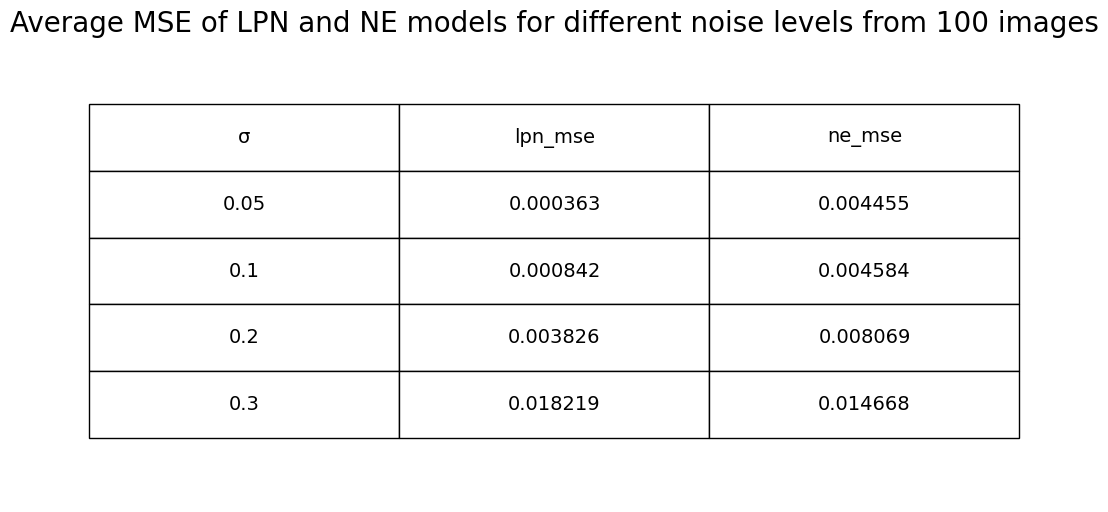

In [86]:
sigma_levels = [0.05, 0.1, 0.2, 0.3]

run_test(sigma_levels, 100, config_paths, weight_paths, dataset_config_path, result_folder)